#Trade

1. Get 'last' price for HK (rather than waiting for close)

#TODO:

1. Need to sort dates out so can retrieve latest market data for prediction
2. Would it help to normalize values? (doesn't appear so)
3. Is backtesting trading strategy realistic?
    a. Look at using https://github.com/quantopian/zipline
4. Hong Kong wouldn't be available within a trading window so may need to remove (or could get current price) (close is 9pm)
5. Are there different settings on the various learners to try e.g. RFC?
6. MLP
    a. Try different solvers and learning rates
    b. Iterate through different hyperparameters and alpha values (for regularization)
7. Can retrieve probability values to decide on confidence? (mlp.predict_proba())
8. Add in commodities

# Train models

In [ ]:
import datetime
import pandas as pd
from trainingData import trainingData

predictionSymbol = '^GSPC' #'^GSPC' #'^IXIC' #symbol for S&P500 (^GSPC) or NASDAQ (^IXIC) or AUS ('^AXJO')
startdate = datetime.date(2012,10,1)
enddate = datetime.date(2017,2,14)
teststartdate = datetime.date(2017,2,15)
delta = range(3, 6)
lags = range(2, 3)

td = trainingData()
td.load(predictionSymbol, startdate, enddate, delta, lags)

In [11]:
import numpy as np

testsize = 0.1
X_train, y_train, X_test, y_test = td.returnDataForClassification(teststartdate, testsize)

# score accuracy of each algorithm
import algorithms as alg
accuracy, rfc = alg.performRFClass(X_train, y_train, X_test, y_test)
print('RFC =', accuracy)
accuracy, knn = alg.performKNNClass(X_train, y_train, X_test, y_test)
print('KNN =', accuracy)
accuracy, svm = alg.performSVMClass(X_train, y_train, X_test, y_test)
print('SVM =', accuracy)
accuracy, ada = alg.performAdaBoostClass(X_train, y_train, X_test, y_test)
print('ADA =', accuracy)
accuracy, gtb = alg.performGTBClass(X_train, y_train, X_test, y_test)
print('GTB =', accuracy)
#accuracy = alg.performQDAClass(X_train, y_train, X_test, y_test)
#print('QDA =', accuracy)
accuracy, mlp = alg.performMLPClass(X_train, y_train, X_test, y_test, (6,6,4))
print('MLP =', accuracy)


RFC = 0.575757575758
KNN = 0.474747474747
SVM = 0.525252525253
ADA = 0.646464646465
GTB = 0.585858585859
MLP = 0.525252525253


# Evaluate for single prediction

In [3]:
import datetime
import pandas as pd
from trainingData import trainingData

predictionSymbol = '^GSPC'

# evaluate for single predictions across all algorithms
startdate = datetime.date(2017,2,10)
enddate = datetime.date(2017,2,21)
delta = range(2, 6)
lags = range(2, 3)

td = trainingData()
td.load(predictionSymbol, startdate, enddate, delta, lags)
predData = td.returnDataForPrediction()

got nasdaq
got sp500
got australia
got hkong
got volatility


In [4]:
#singeDay = predData.loc['20170216'].reshape(1, -1)
singleDay = predData[predData.index == '20170217']
singleDay
##predData = predData[-2::][:1:]

,OutTime2,OutTime3,OutTime4,OutTime5,Return_^AXJO,^AXJOTime2,^AXJOTime3,^AXJOTime4,^AXJOTime5,Return_^IXIC,...,^VIXTime5,Return_^HSI,^HSITime2,^HSITime3,^HSITime4,^HSITime5,Return_Out2,^AXJOTime52,^GSPCTime42,^HSITime32
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-17,0.000813,0.005809,0.00984,0.015137,-0.001843,-0.003645,-0.00241,0.006933,0.005971,0.004072,...,0.058986,0.004674,0.001592,0.006302,0.018693,0.01835,-0.000864,0.0,0.0,0.016731


In [5]:

#td.finalTrainingData.columns[1:].size
prediction = svm.predict(singleDay)
print('svm prediction =', prediction)
prediction = ada.predict(singleDay)
print('ada prediction =', prediction)
prediction = mlp.predict(singleDay)
print('mlp prediction =', prediction)

prediction = rfc.predict(singleDay)
print('rfc prediction =', prediction)
prediction = knn.predict(singleDay)
print('knn prediction =', prediction)
prediction = gtb.predict(singleDay)
print('gtb prediction =', prediction)


svm prediction = [1]
ada prediction = [0]
mlp prediction = [0]
rfc prediction = [0]
knn prediction = [1]
gtb prediction = [0]


# Back test

In [6]:
from datetime import datetime
import pandas as pd
from trainingData import trainingData

predictionSymbol = '^GSPC' #'^GSPC' #'^IXIC' #symbol for S&P500 (^GSPC) or NASDAQ (^IXIC) or AUS ('^AXJO')

startdate = datetime(2016,3,1)
enddate = datetime(2017,2,19)
#startdate = datetime(2014,10,1)
#enddate = datetime(2016,10,30)

delta = range(2, 6)
lags = range(2, 3)

td = trainingData()
td.load(predictionSymbol, startdate, enddate, delta, lags)
predData = td.returnDataForBacktesting()

#predData /= np.std(predData, axis = 0)

# symbol of the stock required for future plotting
symbol = 'S&P-500'

# name of the file of the output of prediction (S&P 500 in this case)
name = 'sp500-2016-17.csv'

# calls the best model previously saved in pickle file and runs it on the test set retutning an array of 0,1 (Down, Up) according to predicted returns
#prediction = pystocks.getPredictionFromBestModel(9, 9, 'sp500', cut, start_test, path_datasets, 'sp500_57.pickle')[0]
prediction = svm.predict(predData)
prediction2 = ada.predict(predData)
prediction3 = mlp.predict(predData)
prediction4 = rfc.predict(predData)
#mlp & ada & svm
#-rfc

# dataframe of S&P 500 historical prices (saved locally from Yahho Finance)
bars = pd.read_csv(name, index_col=0, parse_dates=True)    

# subset of the data corresponding to test set
bars = pd.merge(bars, predData, how='inner', on=None, left_index=True, right_index=True).ix[:,0:6]

# initialize empty dataframe indexed as the bars. There's going to be perfect match between dates in bars and signals 
signals = pd.DataFrame(index=bars.index)

# initialize signals.signal column to zero
signals['signal'] = 0.0
# copying into signals.signal column results of prediction
signals['signal'] = prediction

signals2 = signals.copy()
signals3 = signals.copy()
signals4 = signals.copy()
signals2['signal'] = prediction2
signals3['signal'] = prediction3
signals4['signal'] = prediction4

# replace the zeros with -1 (encoding for Down day)
signals.signal[signals.signal == 0] = -1
signals2.signal[signals2.signal == 0] = -1
signals3.signal[signals3.signal == 0] = -1
signals4.signal[signals4.signal == 0] = -1


#signalsall = pd.merge(signals, signals2, how='inner', on=None, left_index=True, right_index=True)
#signalsall = signalsall[signalsall['signal_x'] == signalsall['signal_y']].ix[:,0:1]
#signalsall.columns = ['signal']

# compute the difference between consecutive entries in signals.signal. As
# signals.signal was an array of 1 and -1 return signals.positions will 
# be an array of 0s and 2s.

#signals['positions'] = signals['signal'].diff()     
#signalsall['positions'] = signalsall['signal'].diff()


got nasdaq
got sp500
got australia
got hkong
got volatility


In [7]:
signalsall = pd.merge(signals, signals2, how='inner', on=None, left_index=True, right_index=True)
signalsall = pd.merge(signalsall, signals3, how='inner', on=None, left_index=True, right_index=True)
signalsall = pd.merge(signalsall, signals4, how='inner', on=None, left_index=True, right_index=True)
signalsall.columns = ['1','2','3','4']
signalsall['signal'] = np.where(signalsall['1'] == signalsall['2'], signalsall['1'], 0)
signalsall['signal'] = np.where(signalsall['3'] == signalsall['signal'], signalsall['signal'], 0)
#signalsall['signal'] = np.where(signalsall['4'] == signalsall['signal'], signalsall['signal'], 0)
#signalsall

# compute the difference between consecutive entries in signals.signal. As
# signals.signal was an array of 1 and -1 return signals.positions will 
# be an array of 0s and 2s.

#signals['positions'] = signals['signal'].diff()     
#signalsall['positions'] = signalsall['signal'].diff()

#signals = signals.head(len(signalsall))

In [8]:
from portfolio import MarketIntradayPortfolio

# calling portfolio evaluation on signals (predicted returns) and bars 
# (actual returns)
portfolio = MarketIntradayPortfolio(symbol, bars, signalsall, 100000, 500)

# backtesting the portfolio and generating returns on top of that 
returns = portfolio.backtest_portfolio()
returns.tail(1)

,price_diff,profit,total,returns
Date,,,,
2017-02-16,-2.419922,-0.0,232834.7135,0.0


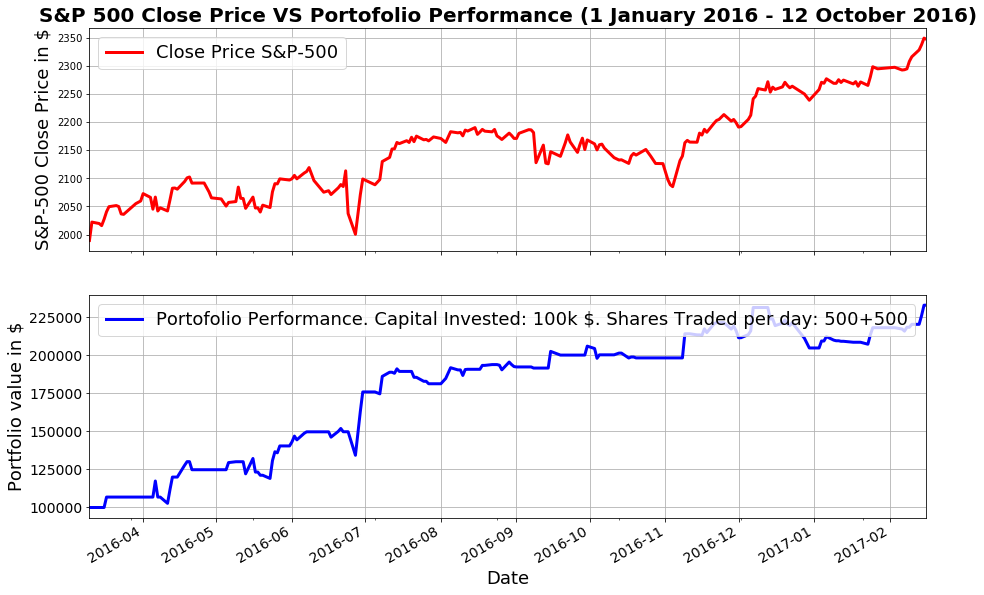

In [9]:

import matplotlib.pyplot as plt

f, ax = plt.subplots(2, sharex=True, figsize=(15,10))
f.patch.set_facecolor('white')
ylabel = symbol + ' Close Price in $'
bars['Close'].plot(ax=ax[0], color='r', lw=3.)    
ax[0].xaxis.grid(True)
ax[0].yaxis.grid(True)
ax[0].set_ylabel(ylabel, fontsize=18)
ax[0].set_xlabel('', fontsize=18)
ax[0].legend(('Close Price S&P-500',), loc='upper left', prop={"size":18})
ax[0].set_title('S&P 500 Close Price VS Portofolio Performance (1 January 2016 - 12 October 2016)', fontsize=20, fontweight="bold")

returns['total'].plot(ax=ax[1], color='b', lw=3.)  
ax[1].xaxis.grid(True)
ax[1].yaxis.grid(True)
ax[1].set_ylabel('Portfolio value in $', fontsize=18)
ax[1].set_xlabel('Date', fontsize=18)
ax[1].legend(('Portofolio Performance. Capital Invested: 100k $. Shares Traded per day: 500+500',), loc='upper left', prop={"size":18})            
plt.tick_params(axis='both', which='major', labelsize=14)
loc = ax[1].xaxis.get_major_locator()
#loc.maxticks[DAILY] = 24

figManager = plt.get_current_fig_manager()
#figManager.window.showMaximized()


plt.show()